# This week, our goal is to develop working models for predicting refractory thyroid cases

### We will utilize every classifcal ML technique

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import umap, shap

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import fisher_exact, mannwhitneyu

## Let's start with refractory thyroid task

In [2]:
data = pd.read_excel('3011979_datasets.xlsx', sheet_name = 'refractory_thyroid', index_col = 0)
print('there are', data.shape[0], 'samples and', data.shape[1], 'features')
data.head(10)

there are 304 samples and 30 features


,age,sex,typeSx,Tprepost,Tsxtx,Ttype,Tsize,Tfocal,Invasion,capsular,...,antitg1,ft41,tsh1,TBSmets,Sitemets,RAI1,RAI2,RAI3,RAI4,Final N
patientID,,,,,,,,,,,,,,,,,,,,,
N001,55,2,1,NaN,6.0,1,2.7,2.0,0.0,0.0,...,368.40,NaN,100.00,0,0.0,0,0,0,0,0
N002,71,2,2,NaN,13.0,1,NaN,NaN,0.0,0.0,...,13.28,0.226,90.18,0,0.0,0,0,0,0,0
N003,62,2,1,2.0,10.0,1,3.3,1.0,0.0,0.0,...,10.20,0.400,72.80,0,0.0,0,0,0,0,0
N004,64,2,1,2.0,4.0,1,3.5,2.0,0.0,0.0,...,25.80,0.250,89.00,0,0.0,0,0,0,0,0
N005,81,2,1,2.0,51.0,1,1.0,2.0,1.0,0.0,...,10.00,0.400,37.72,0,0.0,0,0,0,0,0
N006,74,2,3,NaN,156.0,1,0.6,1.0,0.0,0.0,...,24.06,1.580,53.00,0,0.0,0,0,0,0,0
N007,76,2,3,NaN,38.0,1,7.0,1.0,1.0,0.0,...,582.90,0.220,34.70,0,0.0,0,0,0,0,0
N008,85,2,1,NaN,16.0,2,5.0,1.0,1.0,1.0,...,26.84,0.430,53.90,0,0.0,0,0,0,0,0
N009,56,2,1,NaN,18.0,1,2.8,1.0,1.0,1.0,...,19.32,0.400,100.00,0,0.0,0,0,0,0,0


In [3]:
data.head(10)

,age,sex,typeSx,Tprepost,Tsxtx,Ttype,Tsize,Tfocal,Invasion,capsular,...,antitg1,ft41,tsh1,TBSmets,Sitemets,RAI1,RAI2,RAI3,RAI4,Final N
patientID,,,,,,,,,,,,,,,,,,,,,
N001,55,2,1,NaN,6.0,1,2.7,2.0,0.0,0.0,...,368.40,NaN,100.00,0,0.0,0,0,0,0,0
N002,71,2,2,NaN,13.0,1,NaN,NaN,0.0,0.0,...,13.28,0.226,90.18,0,0.0,0,0,0,0,0
N003,62,2,1,2.0,10.0,1,3.3,1.0,0.0,0.0,...,10.20,0.400,72.80,0,0.0,0,0,0,0,0
N004,64,2,1,2.0,4.0,1,3.5,2.0,0.0,0.0,...,25.80,0.250,89.00,0,0.0,0,0,0,0,0
N005,81,2,1,2.0,51.0,1,1.0,2.0,1.0,0.0,...,10.00,0.400,37.72,0,0.0,0,0,0,0,0
N006,74,2,3,NaN,156.0,1,0.6,1.0,0.0,0.0,...,24.06,1.580,53.00,0,0.0,0,0,0,0,0
N007,76,2,3,NaN,38.0,1,7.0,1.0,1.0,0.0,...,582.90,0.220,34.70,0,0.0,0,0,0,0,0
N008,85,2,1,NaN,16.0,2,5.0,1.0,1.0,1.0,...,26.84,0.430,53.90,0,0.0,0,0,0,0,0
N009,56,2,1,NaN,18.0,1,2.8,1.0,1.0,1.0,...,19.32,0.400,100.00,0,0.0,0,0,0,0,0


## First, check for the extent of missing data

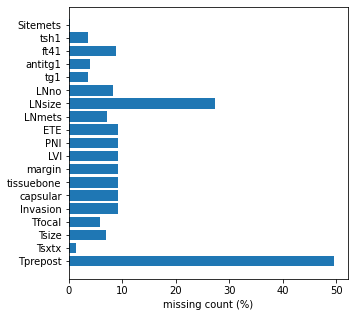

In [4]:
missing_count = pd.isna(data).sum()
missing_count = missing_count.loc[missing_count > 0]

plt.figure(figsize = (5, 5))
plt.barh(range(len(missing_count)), missing_count * 100 / data.shape[0])
plt.yticks(range(len(missing_count)), labels = missing_count.index)
plt.xlabel('missing count (%)')
plt.show()

### Drop Tprepost and LNsize which are missing at >20%

In [5]:
missing_features = data.columns.isin(missing_count.index[missing_count * 100 / data.shape[0] >= 20])
data = data.loc[:, ~missing_features]

## Split input and output data

In [6]:
input_data = data.iloc[:, :-5]
output_data = data['Final N']

In [7]:
print('number of refractory cases:', output_data.sum())

number of refractory cases: 53


## Second, impute missing data
From my experience, imputation does not have a big impact on ML model building. So, a simple imputation should suffice.

**Important** Record the samples with complete data (for using as validation or test data)

In [8]:
complete_samples = input_data.index[~pd.isna(input_data).any(axis = 1)]
print('There are', len(complete_samples), 'samples with no missing data')

There are 245 samples with no missing data


### Distinguish each type of variable

In [9]:
categorical_features = ['typeSx', 'Ttype', 'Sitemets']
binary_features = ['sex', 'Invasion', 'capsular', 'tissuebone', 'margin', 'LVI', 'PNI', 'ETE', 'LNmets', 'TBSmets']
numerical_features = [f for f in input_data.columns if not f in categorical_features and not f in binary_features]

### Check the distribution of numerical features
First on the original scale

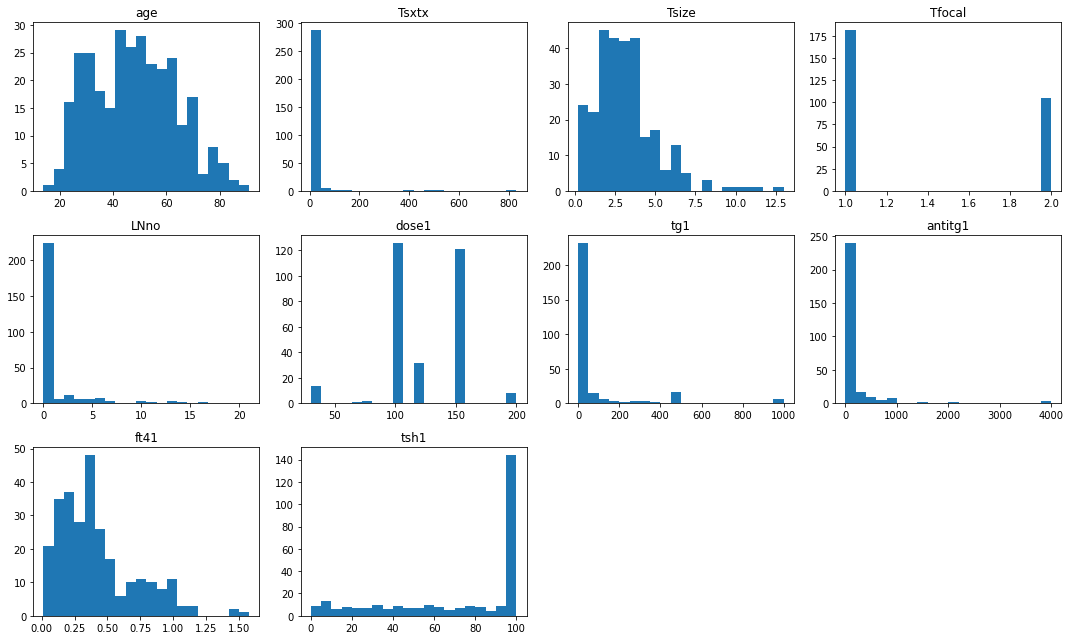

In [10]:
plt.figure(figsize = (15, 9))
k = 1

for f in numerical_features:
    plt.subplot(3, 4, k)
    plt.hist(input_data[f], bins = 20)
    plt.title(f)
    k += 1
        
plt.tight_layout()
plt.show()

Then on a log scale

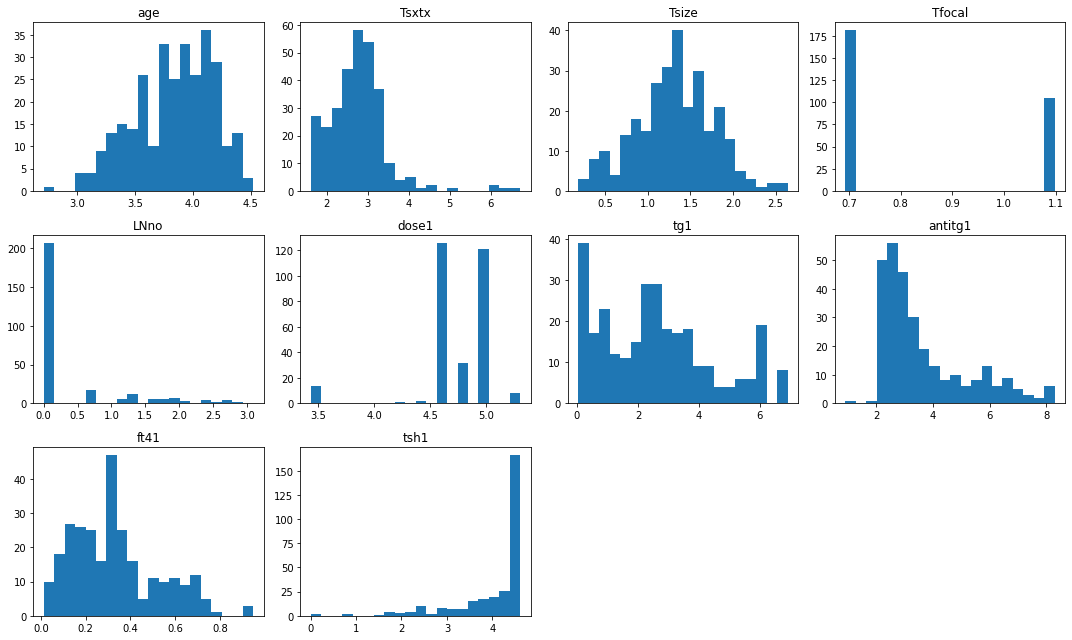

In [11]:
plt.figure(figsize = (15, 9))
k = 1

for f in numerical_features:
    plt.subplot(3, 4, k)
    plt.hist(np.log1p(input_data[f]), bins = 20)
    plt.title(f)
    k += 1
        
plt.tight_layout()
plt.show()

### Apply log-transform to features with wide ranges or non-normal distribution

In [12]:
non_normal_features = ['Tsxtx', 'Tsize', 'LNno', 'dose1', 'tg1', 'antitg1', 'tsh1']

data_trans = input_data.copy()
data_trans[non_normal_features] = np.log1p(data_trans[non_normal_features])

### Calculate data mean and mode for imputation

In [13]:
data_means = data_trans.mean()
data_modes = data_trans.mode().iloc[0, :] ## mode returns multiple rows if there are ties

### Impute data using mode for binary and categorical features and mean for the rest

In [14]:
imputed_value_map = {}

for f in categorical_features:
    imputed_value_map[f] = data_modes[f]
    
for f in binary_features:
    imputed_value_map[f] = data_modes[f]
    
for f in numerical_features:
    imputed_value_map[f] = data_means[f]

data_imputed = data_trans.copy()
data_imputed = data_imputed.fillna(imputed_value_map)
data_imputed.head()

,age,sex,typeSx,Tsxtx,Ttype,Tsize,Tfocal,Invasion,capsular,tissuebone,...,ETE,LNmets,LNno,dose1,tg1,antitg1,ft41,tsh1,TBSmets,Sitemets
patientID,,,,,,,,,,,,,,,,,,,,,
N001,55,2,1,1.945910,1,1.308333,2.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,4.615121,1.780024,5.911880,0.421935,4.615121,0,0.0
N002,71,2,2,2.639057,1,1.323566,1.367133,0.0,0.0,0.0,...,0.0,1.0,0.693147,5.017280,4.486950,2.658860,0.226000,4.512836,0,0.0
N003,62,2,1,2.397895,1,1.458615,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,4.615121,3.427515,2.415914,0.400000,4.301359,0,0.0
N004,64,2,1,1.609438,1,1.504077,2.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,3.433987,1.340250,3.288402,0.250000,4.499810,0,0.0
N005,81,2,1,3.951244,1,0.693147,2.000000,1.0,0.0,1.0,...,1.0,0.0,0.000000,5.017280,3.962716,2.397895,0.400000,3.656356,0,0.0


### Ensure that imputed Tfocal values are integers

In [15]:
data_imputed['Tfocal'] = np.round(data_imputed['Tfocal'])
data_imputed['LNno'] = np.round(data_imputed['LNno'])

data_imputed.head()

,age,sex,typeSx,Tsxtx,Ttype,Tsize,Tfocal,Invasion,capsular,tissuebone,...,ETE,LNmets,LNno,dose1,tg1,antitg1,ft41,tsh1,TBSmets,Sitemets
patientID,,,,,,,,,,,,,,,,,,,,,
N001,55,2,1,1.945910,1,1.308333,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.615121,1.780024,5.911880,0.421935,4.615121,0,0.0
N002,71,2,2,2.639057,1,1.323566,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,5.017280,4.486950,2.658860,0.226000,4.512836,0,0.0
N003,62,2,1,2.397895,1,1.458615,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.615121,3.427515,2.415914,0.400000,4.301359,0,0.0
N004,64,2,1,1.609438,1,1.504077,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.433987,1.340250,3.288402,0.250000,4.499810,0,0.0
N005,81,2,1,3.951244,1,0.693147,2.0,1.0,0.0,1.0,...,1.0,0.0,0.0,5.017280,3.962716,2.397895,0.400000,3.656356,0,0.0


## Third, convert categorical features into one-hot codes
typeSx, Ttype, and Sitemets

In [16]:
def convert_cat(data, feature_name):
    temp = pd.get_dummies(data[feature_name], prefix = feature_name)
    temp = pd.concat([data, temp], axis = 1)
    return temp.drop(feature_name, axis = 1)

data_formatted = data_imputed.copy()

for f in categorical_features:
    data_formatted = convert_cat(data_formatted, f)

data_formatted.head()

,age,sex,Tsxtx,Tsize,Tfocal,Invasion,capsular,tissuebone,margin,LVI,...,typeSx_3,typeSx_4,Ttype_1,Ttype_2,Ttype_3,Sitemets_0.0,Sitemets_1.0,Sitemets_2.0,Sitemets_3.0,Sitemets_4.0
patientID,,,,,,,,,,,,,,,,,,,,,
N001,55,2,1.945910,1.308333,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
N002,71,2,2.639057,1.323566,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
N003,62,2,2.397895,1.458615,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
N004,64,2,1.609438,1.504077,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0
N005,81,2,3.951244,0.693147,2.0,1.0,0.0,1.0,0.0,0.0,...,0,0,1,0,0,1,0,0,0,0


### Check the frequency of binary features

In [17]:
new_binary_features = binary_features.copy()
new_binary_features.extend([f for f in data_formatted.columns if f.split('_')[0] in categorical_features])

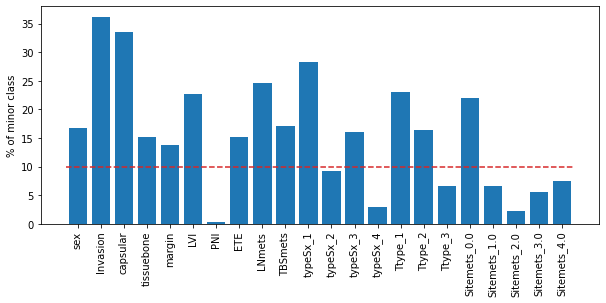

In [18]:
binary_min_count = (data_formatted[new_binary_features] == 1).mean()
binary_min_count[binary_min_count > 0.5] = 1 - binary_min_count[binary_min_count > 0.5]

plt.figure(figsize = (10, 4))
plt.bar(range(len(new_binary_features)), binary_min_count * 100)
plt.plot([-0.5, len(new_binary_features) - 0.5], [10, 10], '--', c = 'tab:red')
plt.xticks(ticks = range(len(new_binary_features)), labels = new_binary_features, rotation = 90)
plt.ylabel('% of minor class')
plt.show()

### Drop binary features with % of minor class lower than 10%

In [19]:
imbalance_binary_features = data_formatted.columns.isin(np.array(new_binary_features)[binary_min_count < 0.1])
data_formatted = data_formatted.loc[:, ~imbalance_binary_features]
data_formatted.head()

,age,sex,Tsxtx,Tsize,Tfocal,Invasion,capsular,tissuebone,margin,LVI,...,tg1,antitg1,ft41,tsh1,TBSmets,typeSx_1,typeSx_3,Ttype_1,Ttype_2,Sitemets_0.0
patientID,,,,,,,,,,,,,,,,,,,,,
N001,55,2,1.945910,1.308333,2.0,0.0,0.0,0.0,0.0,0.0,...,1.780024,5.911880,0.421935,4.615121,0,1,0,1,0,1
N002,71,2,2.639057,1.323566,1.0,0.0,0.0,0.0,0.0,0.0,...,4.486950,2.658860,0.226000,4.512836,0,0,0,1,0,1
N003,62,2,2.397895,1.458615,1.0,0.0,0.0,0.0,0.0,0.0,...,3.427515,2.415914,0.400000,4.301359,0,1,0,1,0,1
N004,64,2,1.609438,1.504077,2.0,0.0,0.0,0.0,0.0,0.0,...,1.340250,3.288402,0.250000,4.499810,0,1,0,1,0,1
N005,81,2,3.951244,0.693147,2.0,1.0,0.0,1.0,0.0,0.0,...,3.962716,2.397895,0.400000,3.656356,0,1,0,1,0,1


### Update the list of binary features

In [20]:
final_binary_features = [f for f in new_binary_features if f in data_formatted.columns]

## Fourth, visualize sample distribution using PCA and UMAP

In [24]:
data_std = (data_formatted - data_formatted.mean()) / data_formatted.std()
pca = PCA(n_components = data_std.shape[1], random_state = 3011979).fit(data_std)
pca_embedded = pca.transform(data_std)

### Tune UMAP's n_neighbors parameter

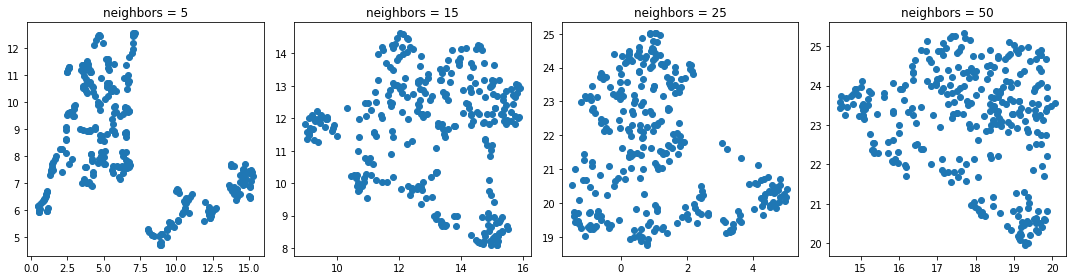

In [25]:
plt.figure(figsize = (15, 4))

for i, neighbor in enumerate([5, 15, 25, 50], start = 1):
    umap_embedded = umap.UMAP(n_neighbors = neighbor, random_state = 3011979).fit_transform(data_std)
    plt.subplot(1, 4, i)
    plt.scatter(umap_embedded[:, 0], umap_embedded[:, 1])
    plt.title('neighbors = ' + str(neighbor))
    
plt.tight_layout()
plt.show()

### Select neighbors = 50

In [26]:
umap_embedded = umap.UMAP(n_neighbors = 50, random_state = 3011979).fit_transform(data_std)

### View scatter plots using Final N as labels

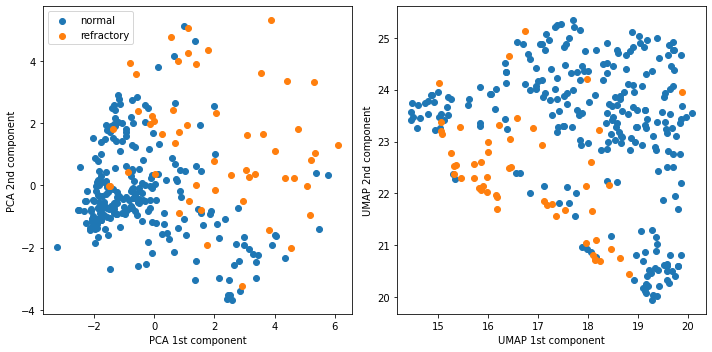

In [27]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.scatter(pca_embedded[output_data == 0, 0], pca_embedded[output_data == 0, 1], label = 'normal')
plt.scatter(pca_embedded[output_data == 1, 0], pca_embedded[output_data == 1, 1], label = 'refractory')
plt.xlabel('PCA 1st component'); plt.ylabel('PCA 2nd component')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(umap_embedded[output_data == 0, 0], umap_embedded[output_data == 0, 1], label = 'normal')
plt.scatter(umap_embedded[output_data == 1, 0], umap_embedded[output_data == 1, 1], label = 'refractory')
plt.xlabel('UMAP 1st component'); plt.ylabel('UMAP 2nd component')

plt.tight_layout()
plt.show()

## Fifth, univariate statistical feature analysis
Fisher's exact test for binary variables (note that we no longer have categorical variables)

Table | Class 0 | Class 1
--- | --- | ---
Label 0 | | 
Label 1 | |

Pandas's [crosstab](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.crosstab.html) function can be used

In [29]:
pd.crosstab(output_data, data_formatted[f])

Sitemets_0.0,0,1
Final N,,
0,19,232
1,48,5


In [28]:
fisher_results = pd.DataFrame(0, index = final_binary_features, columns = ['Minor Freq', 'Odd Ratio', 'P-value'])

for f in final_binary_features:
    table = pd.crosstab(output_data, data_formatted[f])
    temp = (data_formatted[f] == 1).mean()
    
    if temp > 0.5:
        temp = 1 - temp
    
    fisher_results.loc[f, 'Minor Freq'] = temp
    fisher_results.loc[f, ['Odd Ratio', 'P-value']] = fisher_exact(table, alternative = 'two-sided')
    
fisher_results.head(fisher_results.shape[0])

,Minor Freq,Odd Ratio,P-value
sex,0.167763,0.548935,1.069478e-01
Invasion,0.361842,3.291852,1.464189e-03
capsular,0.335526,1.516935,2.010205e-01
tissuebone,0.151316,3.614943,4.976453e-04
margin,0.138158,2.858974,7.229942e-03
LVI,0.226974,2.016807,4.571040e-02
ETE,0.151316,2.801358,5.678924e-03
LNmets,0.246711,3.969766,3.167398e-05
TBSmets,0.171053,23.163743,1.045630e-18
typeSx_1,0.282895,0.268320,3.685369e-05


#### Many binary features are associated with refractory status, especially TBSmets and Sitemets = 0

Next, perform Mann-Whitney U test for numerical features

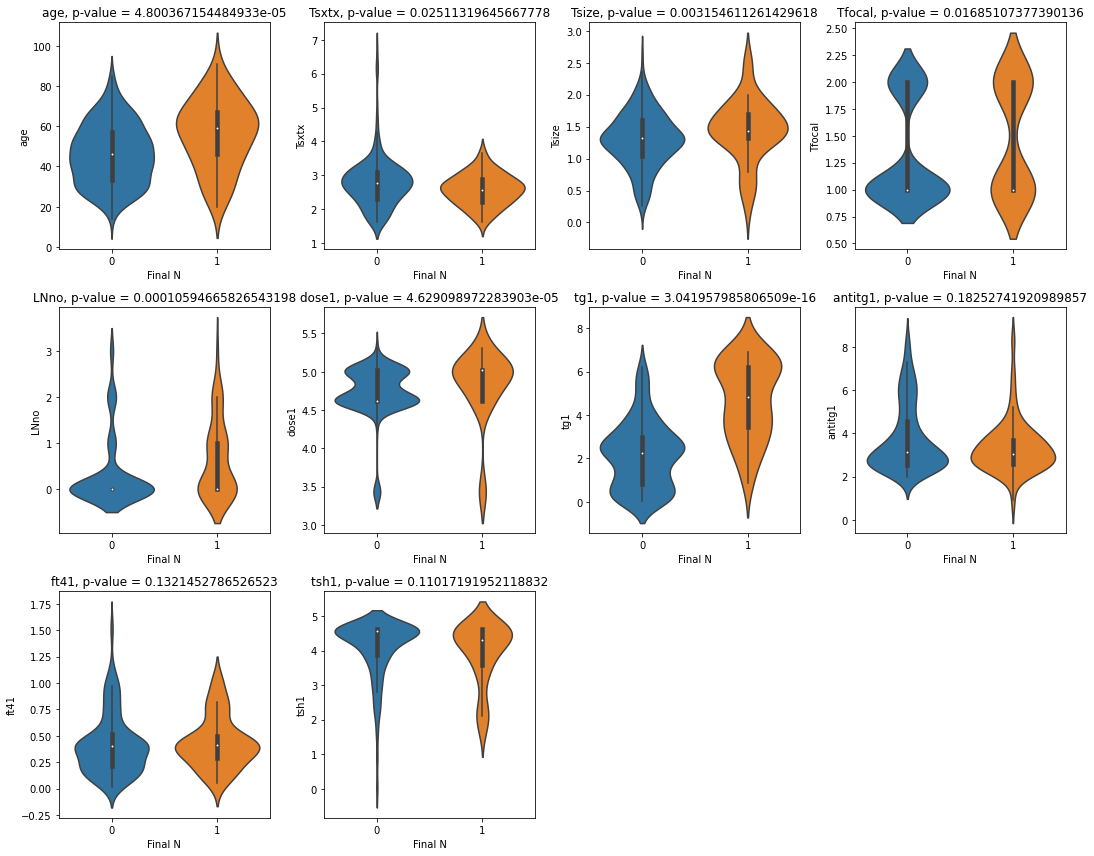

In [30]:
mann_whitney_pval = {f: mannwhitneyu(data_formatted.loc[output_data == 0, f], 
                                     data_formatted.loc[output_data == 1, f])[1]
                     for f in numerical_features}

plt.figure(figsize = (15, 12))
k = 1

for f in numerical_features:
    plt.subplot(3, 4, k)
    temp = pd.concat([data_formatted[f], output_data], axis = 1)
    sns.violinplot(data = temp, x = 'Final N', y = f)
    plt.title(f + ', p-value = ' + str(mann_whitney_pval[f]))
    k += 1
        
plt.tight_layout()
plt.show()

#### tg1 is most clearly associated with refractory status

## Sixth, decide on validation scheme
There are 304 samples, only 53 are refractory

### Cross-validation is preferred over external test
* Not enough refractory cases for an external test set
* 5-fold CV means that there would be only 10 refractory cases in each validation set
* So, we may need to perform either **3-fold CV** or **bootstrapping**

In [21]:
cv_splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 3011979)

## Seventh, preliminary model evaluation
* Logistic regression
* Random forest
* Gradient boosting tree

SVM with radial basis function is unlikely to perform well because we have few data points

### Tune logistic regression model using GridSearchCV

In [32]:
base_logistic = LogisticRegression(solver = 'liblinear', max_iter = 10000, random_state = 3011979)
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}
grid_logistic = GridSearchCV(estimator = base_logistic, param_grid = param_grid,
                             scoring = ['accuracy', 'f1', 'roc_auc', 'average_precision'],
                             refit = False, cv = cv_splitter)

In [34]:
grid_logistic.cv_results_

{'mean_fit_time': array([0.00433246, 0.00231798, 0.00199429, 0.00166392, 0.00199493,
        0.00166217, 0.00199382, 0.00199095, 0.00199461, 0.00199064,
        0.00664846, 0.00299652, 0.01263253, 0.00299215]),
 'std_fit_time': array([1.87277107e-03, 4.57321404e-04, 8.10467325e-07, 4.71374373e-04,
        8.10467325e-07, 4.70302644e-04, 7.86741172e-07, 5.33948804e-06,
        3.37174788e-07, 5.45186135e-06, 3.08287511e-03, 6.51871257e-06,
        9.43785832e-03, 5.84003864e-07]),
 'mean_score_time': array([0.00498533, 0.00432165, 0.0043207 , 0.00432014, 0.00432126,
        0.00365973, 0.00366084, 0.00332435, 0.00398922, 0.00365718,
        0.00398978, 0.00398477, 0.00365718, 0.00332427]),
 'std_score_time': array([8.16731509e-04, 4.69628375e-04, 4.69628375e-04, 4.67830029e-04,
        4.69572129e-04, 4.72057708e-04, 4.72684995e-04, 4.70134046e-04,
        8.14296054e-04, 4.70077860e-04, 1.12391596e-07, 6.29392938e-06,
        4.69909263e-04, 4.70358870e-04]),
 'param_C': masked_array(d

In [33]:
grid_logistic.fit(data_std, output_data)
grid_logistic_result = pd.DataFrame.from_dict(grid_logistic.cv_results_)

### View the best models based on AUROC and AP

In [35]:
print('sorted by AUROC')
temp = grid_logistic_result.sort_values('rank_test_roc_auc')
display(temp[['params', 'mean_test_roc_auc', 'mean_test_average_precision', 
              'mean_test_f1', 'mean_test_accuracy']].head(5))

print('sorted by AP')
temp = grid_logistic_result.sort_values('rank_test_average_precision')
display(temp[['params', 'mean_test_roc_auc', 'mean_test_average_precision', 
              'mean_test_f1', 'mean_test_accuracy']].head(5))

sorted by AUROC


,params,mean_test_roc_auc,mean_test_average_precision,mean_test_f1,mean_test_accuracy
6,"{'C': 0.1, 'penalty': 'l1'}",0.950819,0.852967,0.798460,0.921019
7,"{'C': 0.1, 'penalty': 'l2'}",0.946943,0.854279,0.792023,0.924319
3,"{'C': 0.001, 'penalty': 'l2'}",0.945036,0.801448,0.726173,0.874943
1,"{'C': 0.0001, 'penalty': 'l2'}",0.944341,0.796966,0.722061,0.871643
5,"{'C': 0.01, 'penalty': 'l2'}",0.943975,0.813678,0.749051,0.897949


sorted by AP


,params,mean_test_roc_auc,mean_test_average_precision,mean_test_f1,mean_test_accuracy
8,"{'C': 1, 'penalty': 'l1'}",0.936759,0.865321,0.804967,0.934188
9,"{'C': 1, 'penalty': 'l2'}",0.938269,0.856104,0.777678,0.924319
7,"{'C': 0.1, 'penalty': 'l2'}",0.946943,0.854279,0.792023,0.924319
6,"{'C': 0.1, 'penalty': 'l1'}",0.950819,0.852967,0.798460,0.921019
11,"{'C': 10, 'penalty': 'l2'}",0.922007,0.833685,0.734255,0.911182


#### For imbalance dataset, AP is generally a better metric than AUROC
The best model is L1-penalized with C = 1.0

### Evaluate random forest and gradient boosting tree model
Default hyperparameters

In [36]:
base_rf = RandomForestClassifier(n_estimators = 500, random_state = 3011979)
base_rf_perf = pd.DataFrame(0, index = ['CV fold ' + str(n) for n in range(1, 4)],
                             columns = ['AUROC', 'AP', 'F1', 'Accuracy'])
fold = 1

for train_ind, test_ind in cv_splitter.split(data_std, output_data):
    y_test = output_data.iloc[test_ind]
    base_rf.fit(data_std.iloc[train_ind, :], output_data.iloc[train_ind])
    y_pred = base_rf.predict(data_std.iloc[test_ind, :])
    y_prob = base_rf.predict_proba(data_std.iloc[test_ind, :])[:, 1]
    
    base_rf_perf.loc['CV fold ' + str(fold), :] = [roc_auc_score(y_test, y_prob),
                                      average_precision_score(y_test, y_prob),
                                      f1_score(y_test, y_pred),
                                      accuracy_score(y_test, y_pred)]
    fold += 1

In [37]:
base_gbt = xgb.XGBClassifier(n_estimators = 200, use_label_encoder = False, 
                             tree_method = 'hist', eval_metric = 'logloss')
base_gbt_perf = pd.DataFrame(0, index = ['CV fold ' + str(n) for n in range(1, 4)],
                             columns = ['AUROC', 'AP', 'F1', 'Accuracy'])
fold = 1

for train_ind, test_ind in cv_splitter.split(data_std, output_data):
    X_train = data_std.iloc[train_ind, :]
    X_test = data_std.iloc[test_ind, :]
                
    y_train = output_data.iloc[train_ind]
    y_test = output_data.iloc[test_ind]
                
    base_gbt.fit(X_train, y_train, early_stopping_rounds = 20, verbose = False,
                 eval_set = [(X_train, y_train), (X_test, y_test)])
    
    y_pred = base_gbt.predict(X_test)
    y_prob = base_gbt.predict_proba(X_test)[:, 1]
    base_gbt_perf.loc['CV fold ' + str(fold), :] = [roc_auc_score(y_test, y_prob),
                                      average_precision_score(y_test, y_prob),
                                      f1_score(y_test, y_pred),
                                      accuracy_score(y_test, y_pred)]
    fold += 1

Check the number of iterations used by GBT - We will use this number for RFECV

In [38]:
print(base_gbt.best_iteration)

10


### Summarize prelim model performances

In [39]:
sum_perf = pd.DataFrame(0, index = ['Logistic', 'Random Forest', 'Gradient Boosting Tree'],
                        columns = ['AUROC', 'AP', 'F1', 'Accuracy'])
temp = grid_logistic_result.sort_values('rank_test_average_precision')
sum_perf.loc['Logistic'] = temp[['mean_test_roc_auc', 'mean_test_average_precision', 
                                 'mean_test_f1', 'mean_test_accuracy']].iloc[0, :].values
sum_perf.loc['Random Forest'] = base_rf_perf.mean()
sum_perf.loc['Gradient Boosting Tree'] = base_gbt_perf.mean()
sum_perf.head()

,AUROC,AP,F1,Accuracy
Logistic,0.936759,0.865321,0.804967,0.934188
Random Forest,0.950367,0.840380,0.685877,0.904582
Gradient Boosting Tree,0.921755,0.833817,0.746695,0.917815


## Eighth, perform feature selection

In [22]:
def view_rfe_result(rfecv, metric, model):
    plt.figure(figsize = (6, 4))
    plt.xlabel('Number of features')
    plt.ylabel(metric)
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
    plt.title(model)
    plt.show()

### Logistic regression

X does not have valid feature names, but RFECV was fitted with feature names


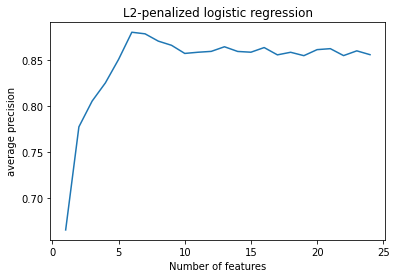

In [25]:
base_logistic = LogisticRegression(penalty = 'l2', C = 1, solver = 'liblinear', max_iter = 10000, random_state = 3011979)
logistic_rfe = RFECV(base_logistic, step = 1, min_features_to_select = 1, 
                     cv = cv_splitter, scoring = 'average_precision', n_jobs = 3).fit(data_std, output_data)

view_rfe_result(logistic_rfe, 'average precision', 'L2-penalized logistic regression')

### Random Forest

X does not have valid feature names, but RFECV was fitted with feature names


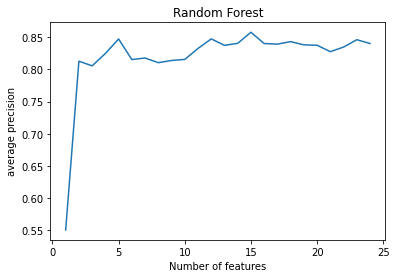

In [42]:
rf_rfe = RFECV(base_rf, step = 1, min_features_to_select = 1, 
               cv = cv_splitter, scoring = 'average_precision', n_jobs = 3).fit(data_std, output_data)

view_rfe_result(rf_rfe, 'average precision', 'Random Forest')

### Gradient Boosting Tree
Set number of estimators to 20 (based on the number of iterations before early stopping)

X does not have valid feature names, but RFECV was fitted with feature names


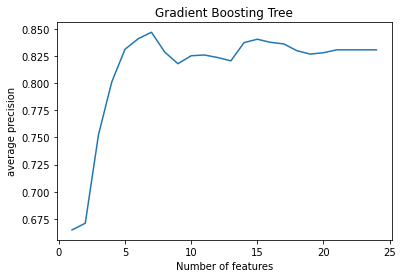

In [26]:
base_gbt = xgb.XGBClassifier(n_estimators = 20, use_label_encoder = False, 
                             tree_method = 'hist', eval_metric = 'logloss')
gbt_rfe = RFECV(base_gbt, step = 1, min_features_to_select = 1, 
                cv = cv_splitter, scoring = 'average_precision', n_jobs = 3).fit(data_std, output_data)

view_rfe_result(gbt_rfe, 'average precision', 'Gradient Boosting Tree')

### Compare the list of selected features

In [27]:
features_logistic = logistic_rfe.feature_names_in_[logistic_rfe.support_]
# features_rf = rf_rfe.feature_names_in_[rf_rfe.support_]
features_gbt = gbt_rfe.feature_names_in_[gbt_rfe.support_]

print('Logistic selected', sorted(features_logistic))
# print('Random Forest selected', sorted(features_rf))
print('Gradient Boosting Tree selected', sorted(features_gbt))

Logistic selected ['LNmets', 'LNno', 'Sitemets_0.0', 'TBSmets', 'tg1', 'typeSx_1']
Gradient Boosting Tree selected ['Invasion', 'Sitemets_0.0', 'TBSmets', 'Tsxtx', 'capsular', 'tg1', 'tsh1']


LNmets, LNno, Sitemets_0.0, TBSmets, tg1, and typeSx_1 are selected by all models

Random forest can handle large number of input features, as expected

## Ninth, time for full model tuning on selected features
Start with logistic models

In [28]:
data_logistic = data_std[features_logistic]
base_logistic = LogisticRegression(solver = 'liblinear', max_iter = 10000, random_state = 3011979)
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

grid_logistic_full = GridSearchCV(estimator = base_logistic, param_grid = param_grid,
                             scoring = ['accuracy', 'f1', 'roc_auc', 'average_precision'],
                             refit = False, cv = cv_splitter)
grid_logistic_full.fit(data_logistic, output_data)
grid_logistic_full_result = pd.DataFrame.from_dict(grid_logistic_full.cv_results_)

Random forest

In [49]:
data_rf = data_std[features_rf]
base_rf = RandomForestClassifier(n_estimators = 500, random_state = 3011979)
param_grid = {'max_depth': [10, 20, None],
              'min_samples_split': [2, 10]}

grid_rf_full = GridSearchCV(estimator = base_rf, param_grid = param_grid,
                             scoring = ['accuracy', 'f1', 'roc_auc', 'average_precision'],
                             refit = False, cv = cv_splitter)
grid_rf_full.fit(data_rf, output_data)
grid_rf_full_result = pd.DataFrame.from_dict(grid_rf_full.cv_results_)

Gradient boosting tree

In [29]:
data_gbt = data_std[features_gbt]
base_gbt = xgb.XGBClassifier(n_estimators = 25, use_label_encoder = False, 
                             tree_method = 'hist', eval_metric = 'logloss')
param_grid = {'min_child_weight': [0.6, 0.7, 0.8, 0.9],
              'max_depth': [2, 5, 10],
              'gamma': [0, 1, 2, 5],
              'colsample_bytree': [0.6, 1.0],
              'subsample': [0.8, 1.0]}

grid_gbt_full = GridSearchCV(estimator = base_gbt, param_grid = param_grid,
                             scoring = ['accuracy', 'f1', 'roc_auc', 'average_precision'],
                             refit = False, cv = cv_splitter)
grid_gbt_full.fit(data_gbt, output_data)
grid_gbt_full_result = pd.DataFrame.from_dict(grid_gbt_full.cv_results_)

### Summarize tuning results

In [30]:
sum_tune_perf = pd.DataFrame(0, index = ['Logistic', 'Random Forest', 'Gradient Boosting Tree'],
                        columns = ['Parameters', 'AUROC', 'AP', 'F1', 'Accuracy'])
temp = grid_logistic_full_result.sort_values('rank_test_average_precision')
sum_tune_perf.loc['Logistic'] = temp[['params', 'mean_test_roc_auc', 'mean_test_average_precision', 
                                 'mean_test_f1', 'mean_test_accuracy']].iloc[0, :].values

# temp = grid_rf_full_result.sort_values('rank_test_average_precision')
# sum_tune_perf.loc['Random Forest'] = temp[['params', 'mean_test_roc_auc', 'mean_test_average_precision', 
#                                  'mean_test_f1', 'mean_test_accuracy']].iloc[0, :].values

temp = grid_gbt_full_result.sort_values('rank_test_average_precision')
sum_tune_perf.loc['Gradient Boosting Tree'] = temp[['params', 'mean_test_roc_auc', 'mean_test_average_precision', 
                                 'mean_test_f1', 'mean_test_accuracy']].iloc[0, :].values

In [32]:
# print('before feature selection')
# display(sum_perf.head())
print('after feature selection')
display(sum_tune_perf.head())

after feature selection


,Parameters,AUROC,AP,F1,Accuracy
Logistic,"{'C': 1, 'penalty': 'l2'}",0.966635,0.895976,0.799862,0.930855
Random Forest,0,0.000000,0.000000,0.000000,0.000000
Gradient Boosting Tree,"{'colsample_bytree': 1.0, 'gamma': 1, 'max_dep...",0.934945,0.901357,0.831439,0.944089


Feature selection and full model tuning benefits Logistic Regression and Gradient Boosting Tree, but not Random Forest (except on F1 score)

The best overall model is Gradient Boosting Tree with 0.95 AUROC, 0.91 AP, 0.84 F1, and 0.95 accuracy

## Tenth, compare the top models on ROC and PR curves

In [33]:
print('best logistic hyperparameters:', grid_logistic_full_result.sort_values('rank_test_average_precision')['params'].iloc[0])
# print('best random forest hyperparameters:', grid_rf_full_result.sort_values('rank_test_average_precision')['params'].iloc[0])
print('best gbt hyperparameters:', grid_gbt_full_result.sort_values('rank_test_average_precision')['params'].iloc[0])

best logistic hyperparameters: {'C': 1, 'penalty': 'l2'}
best gbt hyperparameters: {'colsample_bytree': 1.0, 'gamma': 1, 'max_depth': 10, 'min_child_weight': 0.8, 'subsample': 0.8}


In [34]:
best_logistic = LogisticRegression(penalty = 'l2', C = 1, solver = 'liblinear',
                                   random_state = 3011979)

best_rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, min_samples_split = 10,
                                 random_state = 3011979)

best_gbt = xgb.XGBClassifier(n_estimators = 25, use_label_encoder = False, 
                             tree_method = 'hist', eval_metric = 'logloss',
                             colsample_bytree = 1.0, gamma = 1, max_depth = 10, 
                             min_child_weight = 0.8, subsample = 0.8)

### Record predicted values across cross-validation folds

In [36]:
y_test_cv = []
y_prob_cv = {'Logistic': [], 'RF': [], 'GBT': []}

for train_ind, test_ind in cv_splitter.split(data_std, output_data):
    y_test = output_data.iloc[test_ind]
    y_test_cv.append(y_test)
    
    best_logistic.fit(data_logistic.iloc[train_ind, :], output_data.iloc[train_ind])
    y_prob_cv['Logistic'].append(best_logistic.predict_proba(data_logistic.iloc[test_ind, :])[:, 1])
    
#     best_rf.fit(data_rf.iloc[train_ind, :], output_data.iloc[train_ind])
#     y_prob_cv['RF'].append(best_rf.predict_proba(data_rf.iloc[test_ind, :])[:, 1])
    
    best_gbt.fit(data_gbt.iloc[train_ind, :], output_data.iloc[train_ind])
    y_prob_cv['GBT'].append(best_gbt.predict_proba(data_gbt.iloc[test_ind, :])[:, 1])

### Visualize ROC and PR curves for each fold

In [37]:
def plot_roc_cv(y_test_cv, y_prob_cv):
    for i in range(len(y_test_cv)):
        fpr, tpr, _ = roc_curve(y_test_cv[i], y_prob_cv[i])
        score = roc_auc_score(y_test_cv[i], y_prob_cv[i])
        plt.plot(fpr, tpr, label = 'CV fold ' + str(i + 1) + ' (AUC = ' + str(score)[:4] + ')', alpha = 0.7)
    
    fpr, tpr, _ = roc_curve(np.concatenate(y_test_cv)[:], np.concatenate(y_prob_cv)[:])
    score = roc_auc_score(np.concatenate(y_test_cv)[:], np.concatenate(y_prob_cv)[:])
    plt.plot(fpr, tpr, label = 'model average (AUC = ' + str(score)[:4] + ')', c = 'k')
    
    plt.xlabel('1 - specificity'); plt.ylabel('sensitivity')
    plt.legend()
    plt.axis([0, 1, 0, 1])
    
def plot_pr_cv(ax, y_test_cv, y_prob_cv):
    for i in range(len(y_test_cv)):
        PrecisionRecallDisplay.from_predictions(y_test_cv[i], y_prob_cv[i], name = 'CV fold ' + str(i + 1), ax = ax, alpha = 0.7)
         
    PrecisionRecallDisplay.from_predictions(np.concatenate(y_test_cv)[:], np.concatenate(y_prob_cv)[:], name = 'model average', ax = ax, color = 'k')

    plt.legend()
    plt.axis([0, 1, 0, 1])

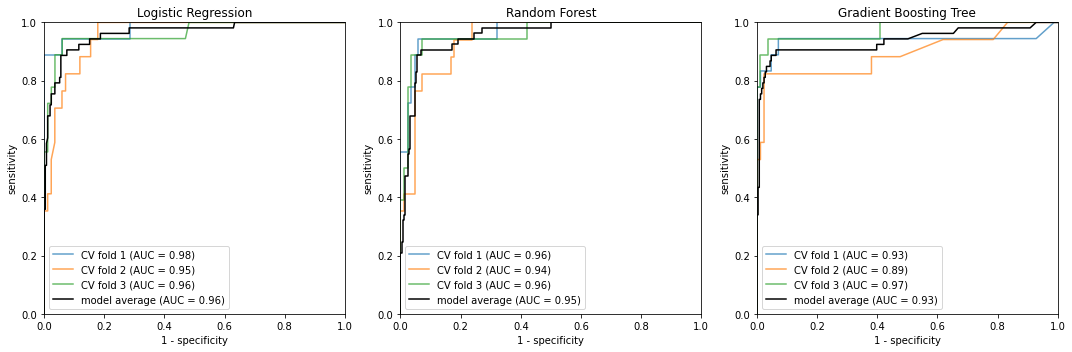

In [58]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plot_roc_cv(y_test_cv, y_prob_cv['Logistic'])
plt.title('Logistic Regression')

plt.subplot(1, 3, 2)
plot_roc_cv(y_test_cv, y_prob_cv['RF'])
plt.title('Random Forest')

plt.subplot(1, 3, 3)
plot_roc_cv(y_test_cv, y_prob_cv['GBT'])
plt.title('Gradient Boosting Tree')

plt.tight_layout()
plt.show()

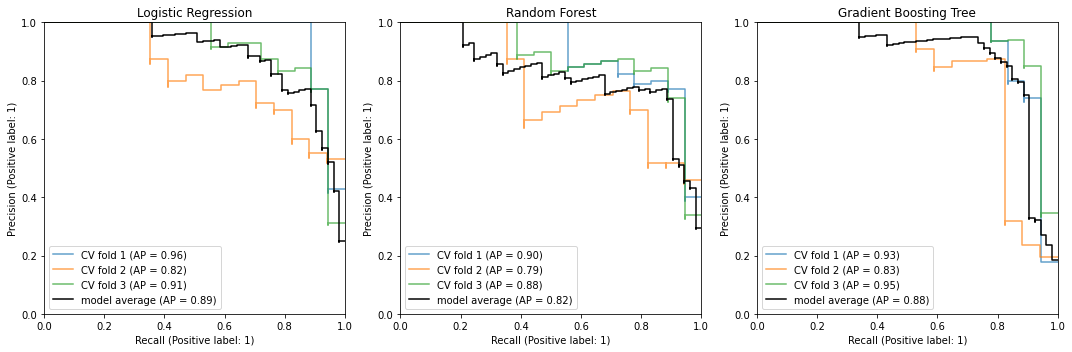

In [59]:
plt.figure(figsize = (15, 5))
ax = plt.subplot(1, 3, 1)
plot_pr_cv(ax, y_test_cv, y_prob_cv['Logistic'])
plt.title('Logistic Regression')

ax = plt.subplot(1, 3, 2)
plot_pr_cv(ax, y_test_cv, y_prob_cv['RF'])
plt.title('Random Forest')

ax = plt.subplot(1, 3, 3)
plot_pr_cv(ax, y_test_cv, y_prob_cv['GBT'])
plt.title('Gradient Boosting Tree')

plt.tight_layout()
plt.show()

## Eleventh, calibrate the probability of GBT model
View the [calibration curve](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html) using sklearn's function

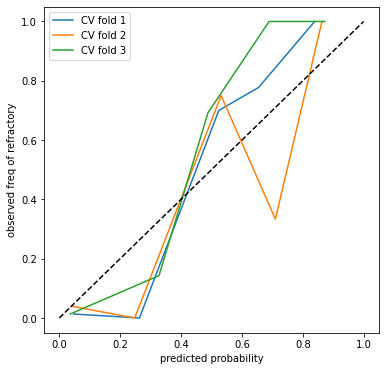

In [62]:
plt.figure(figsize = (6, 6))

for i in range(len(y_test_cv)):
    prob_true, prob_pred = calibration_curve(y_test_cv[i], y_prob_cv['RF'][i], n_bins = 5)
    plt.plot(prob_pred, prob_true, label = 'CV fold ' + str(i + 1))
    
plt.legend()
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('predicted probability'); plt.ylabel('observed freq of refractory')

plt.show()

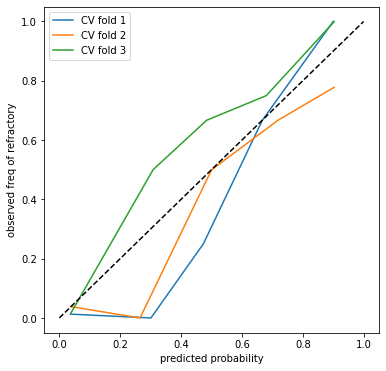

In [61]:
plt.figure(figsize = (6, 6))

for i in range(len(y_test_cv)):
    prob_true, prob_pred = calibration_curve(y_test_cv[i], y_prob_cv['Logistic'][i], n_bins = 5)
    plt.plot(prob_pred, prob_true, label = 'CV fold ' + str(i + 1))
    
plt.legend()
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('predicted probability'); plt.ylabel('observed freq of refractory')

plt.show()

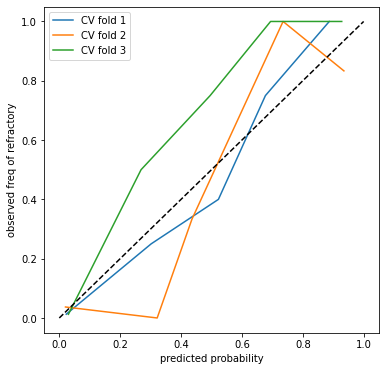

In [60]:
plt.figure(figsize = (6, 6))

for i in range(len(y_test_cv)):
    prob_true, prob_pred = calibration_curve(y_test_cv[i], y_prob_cv['GBT'][i], n_bins = 5)
    plt.plot(prob_pred, prob_true, label = 'CV fold ' + str(i + 1))
    
plt.legend()
plt.plot([0, 1], [0, 1], '--k')
plt.xlabel('predicted probability'); plt.ylabel('observed freq of refractory')

plt.show()

Unfortunately, we don't have enough data to calibrate the model's output

## Twelfth, explore the best GBT model's behaviors
Note that we can refit the model on the non-standardized data so that the results are easier to interpret

In [38]:
best_gbt.fit(data_formatted[features_gbt], output_data)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eval_metric='logloss', gamma=1,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=0.8, missing=nan, monotone_constraints='()',
              n_estimators=25, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Fit SHAP to the best model and dataset

In [39]:
explainer = shap.Explainer(best_gbt)
shap_values = explainer(data_formatted[features_gbt])
shap.initjs()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Contribution of each feature on the first sample's prediction

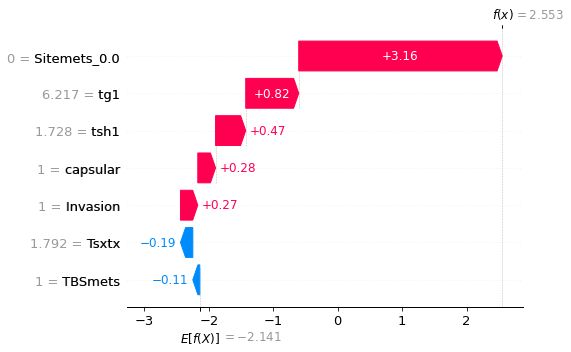

In [46]:
fig = shap.plots.waterfall(shap_values[9], show = False)
plt.tight_layout()
plt.savefig('../../Lifelong Learning/EP7_shap_v1.svg', dpi = 300)

In [71]:
shap.plots.force(shap_values[9])

### View the overall importance of each feature

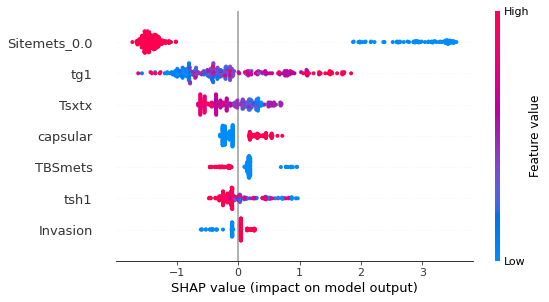

In [48]:
fig = shap.plots.beeswarm(shap_values, show = False)
plt.tight_layout()
plt.savefig('../../Lifelong Learning/EP7_shap_v2.svg', dpi = 300)

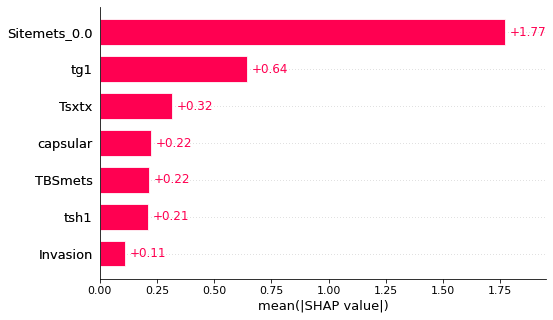

In [73]:
shap.plots.bar(shap_values)